# From Scratch: Training a Neural Network to Classify Spiral Datasets 2

## What's new?

- SGD: NN is trained on mini-batches instead of the entire dataset.
- Test set: split the dataset into training/test data to evaluate test accuracy on unseen data.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('classic')
plt.style.use('seaborn')

## Generate Data

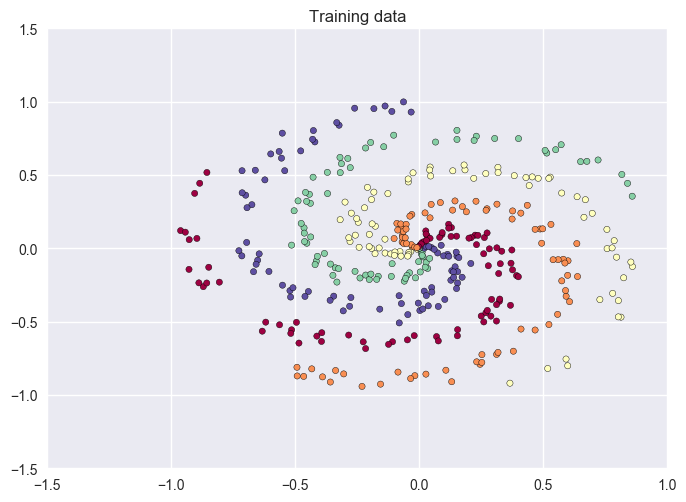

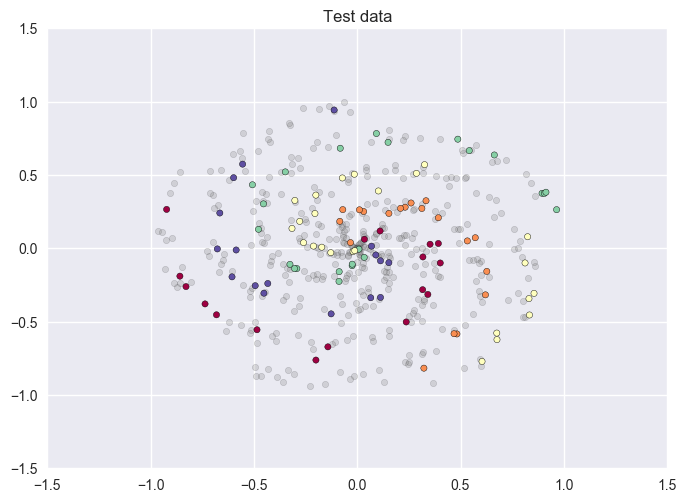

In [2]:
N = 100  # num of points per class
D = 2  # data dimension
K = 5  # num of classes, i.e. spirals


# Create "containers" to store training data and test data
# Each row -> a training example
trainX = np.zeros((N* K,D)) 
trainY = np.zeros((N* K, 1))

# Test set of size 1/10 of the training set
test_size = int(N* K/ 5)
testX = np.zeros((test_size, D))
testY = np.zeros((test_size, 1))

c = 2* math.pi* (K-1) / K
for j in range(K):
    ix = range(N* j, N* (j+1))
    
    # Radius
    r = np.linspace(0., 1, N)

    # Angle
    t = np.linspace(j* c, (j + 1)* c, N) + np.random.randn(N)* .2
    
    trainX[ix] = np.c_[r* np.sin(t), r* np.cos(t)]
    trainY[ix] = j
    
    
# Shuffle the data for SGD and split training/test set
Z = np.hstack((trainX, trainY))
np.random.shuffle(Z)

# Training set
trainX = Z[:-test_size, :2]
trainY = Z[:-test_size, 2].astype('uint8')
    
# Test set
# Note: we shuffle the data randomly, so the test set is random (may not be uniform)
testX = Z[-test_size:, :2]
testY = Z[-test_size:, 2].astype('uint8')
    
# Plot training set
plt.title('Training data')
plt.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=plt.cm.Spectral)
plt.show()

# Plot test set
# Use gray dots to denote training data point
plt.title('Test data')
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
plt.scatter(testX[:, 0], testX[:, 1], c=testY, cmap=plt.cm.Spectral)
plt.show()

## Define Model

In [3]:
H = 100  # num of hidden units

W1 = np.random.randn(D,H)*1e-2
b1 = np.zeros((1,H))
W2 = np.random.randn(H,K)*1e-2
b2 = np.zeros((1,K))

## Training

### Extract mini-batch from the entire dataset

In [4]:
mini_batch = np.random.randint(len(trainX), size=10)
# print(type(mini_batch))
# print(mini_batch)

X = trainX[mini_batch]
y = trainY[mini_batch]
# print(X)
# print(y)

### Training iteration

In [5]:
loss_lst = []

In [6]:
# Hyperparameters
lr = 1e-0
reg = 1e-6  # regularization strength

N = trainX.shape[0]
batch_size = int(N / 5)

# Gradient descent loop
epoch = 10000
for i in range(epoch+1):
    
    """
    Sample a mini-batch
    """
    mini_batch = np.random.randint(N, size=batch_size)
    X = trainX[mini_batch]
    y = trainY[mini_batch]
    
    """
    Forward-propagation
    """
    # Hidden layer
    Y1 = X.dot(W1) + b1
    H1 = np.maximum(Y1, 0)  # relu activation

    # Output layer
    Y2 = H1.dot(W2) + b2

    # Subtract max. output for numerical stability
    Y2 -= np.amax(Y2, axis=1, keepdims=True)

    # Softmax
    exp_Y2 = np.exp(Y2)
    softmax = exp_Y2 / exp_Y2.sum(axis=1, keepdims=True)

    # Compute loss: average cross-entropy loss and regularization loss
    Loss_i = -np.log(softmax[range(batch_size),y])  # CE loss for each training example

    data_loss = Loss_i.mean()
    reg_loss = 0.5* reg* (np.sum(W1**2)+ np.sum(W2**2))
    Loss = data_loss + reg_loss

    loss_lst.append(Loss)

    if i % 500 == 0: print('Epoch {0}: loss {1}'.format(i, Loss.round(4)))

    """
    Back-propagation
    Order: dY2 -> dW2, db2, dH1 -> dY1 -> dW1, db1
    """
    # dY2
    dY2 = softmax
    dY2[range(batch_size),y] -= 1
    dY2 /= N

    # dW2 & db2
    dW2 = H1.T.dot(dY2)
    db2 = dY2.sum(axis=0, keepdims=True)

    # dH1
    dH1 = dY2.dot(W2.T)

    # dY1
    dY1 = dH1* (Y1 > 0)

    # dW1 & db1
    dW1 = X.T.dot(dY1)
    db1 = dY1.sum(axis=0, keepdims=True)

    # Add up regularization losses
    dW2 += reg* W2
    dW1 += reg* W1


    """
    Parameter update
    """
    W1 -= lr* dW1
    b1 -= lr* db1
    W2 -= lr* dW2
    b2 -= lr* db2

Epoch 0: loss 1.6095
Epoch 500: loss 1.4692
Epoch 1000: loss 1.4213
Epoch 1500: loss 1.3078
Epoch 2000: loss 1.2719
Epoch 2500: loss 1.0055
Epoch 3000: loss 0.7382
Epoch 3500: loss 0.6182
Epoch 4000: loss 0.4596
Epoch 4500: loss 0.5322
Epoch 5000: loss 0.4523
Epoch 5500: loss 0.395
Epoch 6000: loss 0.2937
Epoch 6500: loss 0.3148
Epoch 7000: loss 0.3261
Epoch 7500: loss 0.2501
Epoch 8000: loss 0.1607
Epoch 8500: loss 0.2104
Epoch 9000: loss 0.2435
Epoch 9500: loss 0.1807
Epoch 10000: loss 0.1506


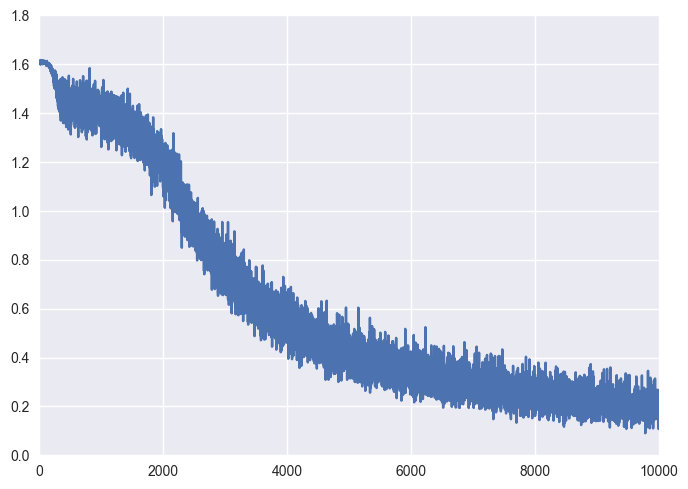

In [7]:
plt.plot(loss_lst)
plt.show()

## Evaluate Training Accuracy and Plot Decision Boundary

In [8]:
def evaluate_and_plot(X, Y, W1, b1, W2, b2, evaluate=True, plot=True):
    if evaluate:
        # Compute output
        Y1 = X.dot(W1) + b1
        H1 = np.maximum(Y1, 0)
        Y2 = H1.dot(W2) + b2

        # Compute training accuracy
        pred = Y2.argmax(axis=1)
        accu = np.mean(pred == Y).round(2)
        print('Accuracy: {0}'.format(accu))
        
    if plot:
        # Plot the resulting classifier with training data
        h = 0.01

        # Pick boundaries of x and y
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Forward pass to compute output
        Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

        plt.show()

Accuracy: 0.94


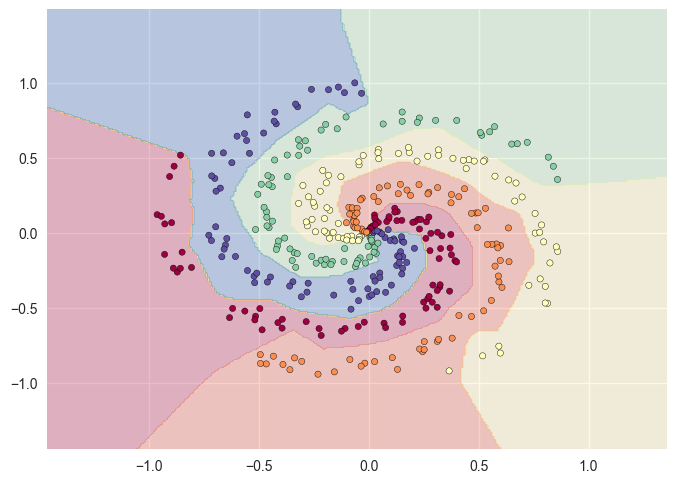

In [9]:
# Evaluate on training set
evaluate_and_plot(trainX, trainY, W1, b1, W2, b2)

## Evaluate Test Accuracy 

Accuracy: 0.93


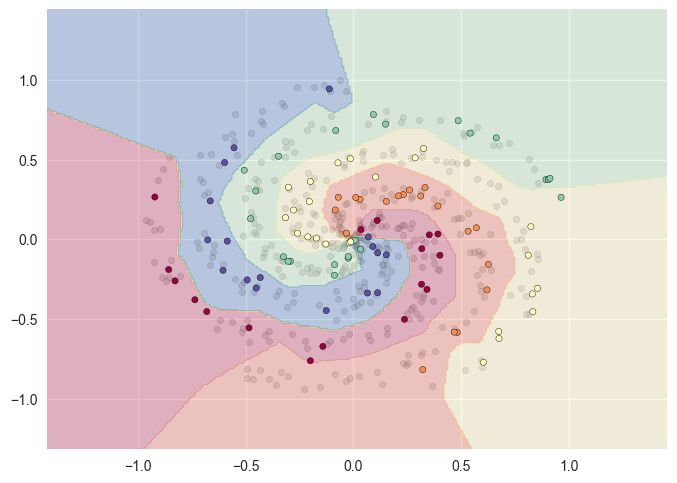

In [10]:
# Evaluate on test set
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
evaluate_and_plot(testX, testY, W1, b1, W2, b2)